# feature discovery to programatically model a patient floor of a hospital 

~~the problem of modeling a patient floor is well suited to a constraint programming model. however, we have some work to do in order to understand what the constraints that must be passed to the model are. we want to be able to do this with the minimum level of information that we are likely to recieve when we are asked to provide pricing for a project. we would expect to know who the client is, what the floor type is, and the number of beds on the floor. these will be our first few features. but we also need to say something about what the shape of the building is likely to be. whather it's kind of square or more of a rectangle. we'll call this aspect_ratio, and add this to the little list of required features.~~

~~so here goes. we'll start by setting up a dataframe with the features I mentioned above for for a number of projects, as well as several targets we will want to solve for~~

ps, redoing this with Adam's measurements. better data, but smaller set, so I'll just be doing some basic plots at the moment

In [62]:
import pandas as pd
import numpy as np
import numpy.linalg as la
pd.options.display.float_format = '{:.2f}'.format
df = pd.read_csv('areas.csv')
df = df.set_index('hospital')
df = df.dropna(axis=1, how='all')
df

,gsf,usf,nsf,client,floor_type,floor,floors_in_bldg,beds,stairs,public_elevators,patient_elevators,clean_soiled_elevators,trash_linen_soiled_chutes,electrical_rooms,idf_rooms,mech_rooms_shafts
hospital,,,,,,,,,,,,,,,,
Multicare Auburn,16119,14359,13469,mc,ms,2,2,24,2,0,1,0,0,1,1,2
Multicare Covington,19145,16918,15677,mc,ms,3,4,24,2,0,2,0,0,1,1,2
Multicare Rainier,18391,16267,15443,mc,ms,5,8,18,2,0,2,1,0,1,1,5
SMMC ph1,29189,25818,24315,cf,ms,7,8,32,2,3,4,0,2,2,2,6
SMMC ph2,12660,10574,9809,cf,icu,5,8,18,1,0,1,0,0,1,1,5
Forest A,35076,28802,26486,sc,pe,3,7,32,3,4,3,0,2,3,2,3
Forest B,23189,18753,16833,sc,pe,8,8,20,2,4,2,0,0,1,2,5


~~doing some basic math to add a couple columns. aspect ratio to use as a feature, sqft per bed to use as a target~~
this time we'll do gsf, usf, and nsf per bed, as well as the client_code and floor_code because why not

In [63]:

df = df.copy()
floor_types, floor_codes = [(df['floor_type'] == 'ms'), (df['floor_type'] == 'ldrp'), (df['floor_type'] == 'nicu'), (df['floor_type'] == 'icu'), (df['floor_type'] == 'pe'), (df['floor_type'] == 'uk'), (df['floor_type'] == 'ccu')], [1,2,3,4,5,6,7]
df['floor_code'] = np.select(floor_types, floor_codes)
clients, client_codes = [(df['client'] == 'mc'), (df['client'] == 'swedish'), (df['client'] == 'sc'), (df['client'] == 'sc'), (df['client'] == 'cf')], [1,2,3,4,5]
df['client_code'] = np.select(clients, client_codes)
df['gsf_per_bed'] = round(df['gsf'] / df['beds'])
df['usf_per_bed'] = round(df['usf'] / df['beds'])
df['nsf_per_bed'] = round(df['nsf'] / df['beds'])
df['total_diff_usf_to_gsf'] = round(df['gsf'] - df['usf'])
df['pct_diff_usf_to_gsf'] = df['total_diff_usf_to_gsf'] / df['gsf']
df = df[['client', 'client_code', 'floor_type', 'floor_code', 'beds', 'gsf', 'gsf_per_bed', 'usf_per_bed', 'nsf_per_bed', 'total_diff_usf_to_gsf', 'pct_diff_usf_to_gsf']]
df = df.sort_values(by=['beds', 'gsf_per_bed'])
df

,client,client_code,floor_type,floor_code,beds,gsf,gsf_per_bed,usf_per_bed,nsf_per_bed,total_diff_usf_to_gsf,pct_diff_usf_to_gsf
hospital,,,,,,,,,,,
SMMC ph2,cf,5,icu,4,18,12660,703.00,587.00,545.00,2086,0.16
Multicare Rainier,mc,1,ms,1,18,18391,1022.00,904.00,858.00,2124,0.12
Forest B,sc,3,pe,5,20,23189,1159.00,938.00,842.00,4436,0.19
Multicare Auburn,mc,1,ms,1,24,16119,672.00,598.00,561.00,1760,0.11
Multicare Covington,mc,1,ms,1,24,19145,798.00,705.00,653.00,2227,0.12
SMMC ph1,cf,5,ms,1,32,29189,912.00,807.00,760.00,3371,0.12
Forest A,sc,3,pe,5,32,35076,1096.00,900.00,828.00,6274,0.18


In [64]:
df['mean_gsf_per_bed'] = df['gsf_per_bed'].mean()
df['mean_usf_per_bed'] = df['usf_per_bed'].mean()
df['mean_nsf_per_bed'] = df['nsf_per_bed'].mean()
df['mean_total_diff_usf_to_gsf'] = df['total_diff_usf_to_gsf'].mean()
df['mean_pct_diff_usf_to_gsf'] = df['pct_diff_usf_to_gsf'].mean()
df

,client,client_code,floor_type,floor_code,beds,gsf,gsf_per_bed,usf_per_bed,nsf_per_bed,total_diff_usf_to_gsf,pct_diff_usf_to_gsf,mean_gsf_per_bed,mean_usf_per_bed,mean_nsf_per_bed,mean_total_diff_usf_to_gsf,mean_pct_diff_usf_to_gsf
hospital,,,,,,,,,,,,,,,,
SMMC ph2,cf,5,icu,4,18,12660,703.00,587.00,545.00,2086,0.16,908.86,777.00,721.00,3182.57,0.14
Multicare Rainier,mc,1,ms,1,18,18391,1022.00,904.00,858.00,2124,0.12,908.86,777.00,721.00,3182.57,0.14
Forest B,sc,3,pe,5,20,23189,1159.00,938.00,842.00,4436,0.19,908.86,777.00,721.00,3182.57,0.14
Multicare Auburn,mc,1,ms,1,24,16119,672.00,598.00,561.00,1760,0.11,908.86,777.00,721.00,3182.57,0.14
Multicare Covington,mc,1,ms,1,24,19145,798.00,705.00,653.00,2227,0.12,908.86,777.00,721.00,3182.57,0.14
SMMC ph1,cf,5,ms,1,32,29189,912.00,807.00,760.00,3371,0.12,908.86,777.00,721.00,3182.57,0.14
Forest A,sc,3,pe,5,32,35076,1096.00,900.00,828.00,6274,0.18,908.86,777.00,721.00,3182.57,0.14


In [60]:
gsf = df.iloc[0,5]
dif = df.iloc[0,9]
dif / gsf

0.16477093206951027

now we'll get out just the features and the target we hope to use in our solution. I'm also taking the logs of the number of beds and the sqft per bed to tigthen up the solution

In [24]:
df_reduced = df.iloc[:,4:].copy()
df_reduced = df_reduced.reset_index(drop=True)
# df_reduced = np.log(df_reduced)
df_reduced

,beds,gsf_per_bed,usf_per_bed,nsf_per_bed
0,18,703.0,587.0,545.0
1,18,1022.0,904.0,858.0
2,20,1159.0,938.0,842.0
3,24,672.0,598.0,561.0
4,24,798.0,705.0,653.0
5,32,912.0,807.0,760.0
6,32,1096.0,900.0,828.0


In [25]:
Y = df_reduced['beds']
X1 = df_reduced['gsf_per_bed']
X2 = df_reduced['usf_per_bed']
X3 = df_reduced['nsf_per_bed']
# Mean X and Y
mean_y = np.mean(Y)
mean_x1 = np.mean(X1)
mean_x2 = np.mean(X2)
mean_x3 = np.mean(X3)
 
# Total number of values
n = len(X1)

# Using the formula to calculate 'm' and 'c'
numer = 0
denom = 0
for i in range(n):
    numer += (X1[i] - mean_x1) * (Y[i] - mean_y)
    denom += (X1[i] - mean_x1) ** 2
    m1 = numer / denom
    c1 = mean_y - (m1 * mean_x1)
numer = 0
denom = 0
for i in range(n):
    numer += (X2[i] - mean_x2) * (Y[i] - mean_y)
    denom += (X2[i] - mean_x2) ** 2
    m2 = numer / denom
    c2 = mean_y - (m2 * mean_x2)
numer = 0
denom = 0
for i in range(n):
    numer += (X3[i] - mean_x3) * (Y[i] - mean_y)
    denom += (X3[i] - mean_x3) ** 2
    m3 = numer / denom
    c3 = mean_y - (m3 * mean_x3)
numer = 0
denom = 0
 
# Printing coefficients
print("Coefficients1")
print(m1, c1)
print("Coefficients2")
print(m2, c2)
print("Coefficients3")
print(m3, c3)

Coefficients1
0.004874015798890331 19.57021592677996
Coefficients2
0.0072904934400779275 18.33528659705945
Coefficients3
0.008533184606804238 17.847573898494144


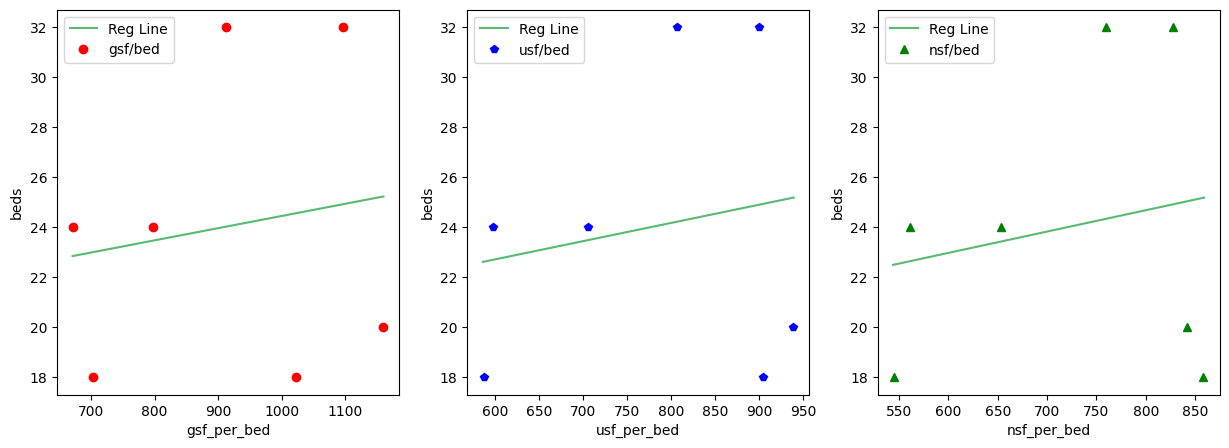

In [26]:
import matplotlib.pyplot as plt 
max_x1 = np.max(X1) + 1
min_x1 = np.min(X1) - 1
x1 = np.linspace(min_x1, max_x1, 1000)
max_x2 = np.max(X2) + 1
min_x2 = np.min(X2) - 1
x2 = np.linspace(min_x2, max_x2, 1000)
max_x3 = np.max(X3) + 1
min_x3 = np.min(X3) - 1
x3 = np.linspace(min_x3, max_x3, 1000)
y1 = c1 + m1 * x1
y2 = c2 + m2 * x2
y3 = c3 + m3 * x3

plt.figure().set_size_inches(15,5)
plt.subplot(131)
plt.plot(x1, y1, color='#58b970', label='Reg Line')
plt.plot(X1, Y, 'ro', label='gsf/bed') 
plt.xlabel('gsf_per_bed')
plt.ylabel('beds')
plt.legend()
plt.subplot(132)
plt.plot(x2, y2, color='#58b970', label='Reg Line')
plt.plot(X2, Y,'bp', label='usf/bed') 
plt.xlabel('usf_per_bed')
plt.ylabel('beds')
plt.legend()
plt.subplot(133)
plt.plot(x3, y3, color='#58b970', label='Reg Line')
plt.plot(X3, Y, 'g^', label='nsf/bed') 
plt.xlabel('nsf_per_bed')
plt.ylabel('beds')
plt.legend()
plt.show()